In [ ]:
!pip install torchviz torch-summary qiskit qiskit_machine_learning

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 148.7/148.7 kB 15.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 100.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 99.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 241.5/241.5 kB 30.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 17.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 94.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 15.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
import os
import random

import numpy as np
import pandas as pd

from skimage import io

from sklearn.model_selection import train_test_split
from sklearn.linear_model import Perceptron
from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Pytorch
import torch, torchvision, torch.utils
from torch import Tensor
from torch import cat
from torch.autograd.grad_mode import no_grad
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch.optim as optim
from torch.nn import (
    Module,
    Conv2d,
    Linear,
    Dropout2d,
    NLLLoss, BCELoss, CrossEntropyLoss, MSELoss,
    MaxPool2d,
    Flatten,
    Sequential,
    ReLU,
)

import torch.nn.functional as F
from torchviz import make_dot
from torchsummary import summary


# Qiskit
from qiskit import Aer, QuantumCircuit
from qiskit.utils import QuantumInstance
from qiskit.opflow import AerPauliExpectation
from qiskit.circuit import Parameter
from qiskit.circuit.library import RealAmplitudes, ZZFeatureMap
from qiskit.quantum_info import DensityMatrix, entanglement_of_formation
from qiskit.visualization import plot_state_city
from qiskit_machine_learning.neural_networks import TwoLayerQNN
from qiskit_machine_learning.connectors import TorchConnector

<ipython-input-3-d3e05d7acf9f>:29: DeprecationWarning: The ``qiskit.opflow`` module is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/opflow_migration.
  from qiskit.opflow import AerPauliExpectation


In [ ]:
def matrix_confusion(yt, yp):
    data = {'Y_Real': yt,
            'Y_Prediccion': yp}

    df = pd.DataFrame(data, columns=['Y_Real','Y_Prediccion'])
    confusion_matrix = pd.crosstab(df['Y_Real'], df['Y_Prediccion'], rownames=['Real'], colnames=['Predicted'])
    sns.heatmap(confusion_matrix, annot=True, fmt='g')

    plt.show()

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
#CHANGE BATCH SIZE TO 8

In [ ]:
train_data = torchvision.datasets.ImageFolder('/content/gdrive/MyDrive/Chest_X_ray/train', transform=transforms.Compose([transforms.ToTensor()]))
test_data = torchvision.datasets.ImageFolder('/content/gdrive/MyDrive/Chest_X_ray/test', transform=transforms.Compose([transforms.ToTensor()]))

In [ ]:
train_data[0][0].shape

torch.Size([3, 640, 640])

In [ ]:
train_loader = DataLoader(train_data, shuffle=True, batch_size=8)
test_loader = DataLoader(test_data, shuffle=True, batch_size=1)
confirm = DataLoader(train_data, shuffle=True, batch_size=1)

In [ ]:
# Normal (0) and True, Pneumonia (1)
print((train_loader.dataset.class_to_idx))

{'NORMAL': 0, 'PNEUMONIA': 1}


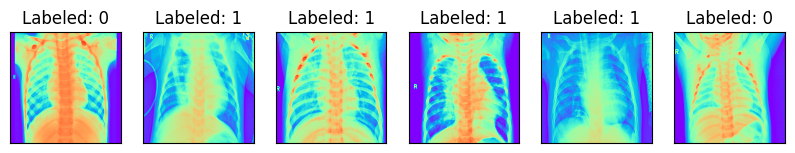

In [ ]:
n_samples_show = 6

data_iter = iter(train_loader)
fig, axes = plt.subplots(nrows=1, ncols=n_samples_show, figsize=(10, 10))

while n_samples_show > 0:
    images, targets = data_iter.__next__()

    axes[n_samples_show - 1].imshow(images[0, 0].numpy().squeeze(), cmap=plt.cm.rainbow)
    axes[n_samples_show - 1].set_xticks([])
    axes[n_samples_show - 1].set_yticks([])
    axes[n_samples_show - 1].set_title(f"Labeled: {targets[0].item()}")

    n_samples_show -= 1

In [ ]:
qi = QuantumInstance(Aer.get_backend("aer_simulator_statevector"))

<ipython-input-11-ecb458de1ae3>:1: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  qi = QuantumInstance(Aer.get_backend("aer_simulator_statevector"))


In [ ]:
def create_qnn():
    feature_map = ZZFeatureMap(2)
    ansatz = RealAmplitudes(2, reps=1)
    qnn = TwoLayerQNN(
        2,
        feature_map,
        ansatz,
        input_gradients=True,
        exp_val=AerPauliExpectation(),
        quantum_instance=qi,
    )
    return qnn

In [ ]:
qnn = create_qnn()

<ipython-input-12-7546e5320c61>:9: DeprecationWarning: The class ``qiskit.opflow.expectations.aer_pauli_expectation.AerPauliExpectation`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/opflow_migration.
  exp_val=AerPauliExpectation(),


In [ ]:
qnn.circuit.draw()

┌──────────────────────────┐┌──────────────────────────────────────┐
q_0: ┤0                         ├┤0                                     ├
     │  ZZFeatureMap(x[0],x[1]) ││  RealAmplitudes(θ[0],θ[1],θ[2],θ[3]) │
q_1: ┤1                         ├┤1                                     ├
     └──────────────────────────┘└──────────────────────────────────────┘

In [ ]:
qnn.feature_map.decompose().draw()

┌───┐┌─────────────┐                                          ┌───┐»
q_0: ┤ H ├┤ P(2.0*x[0]) ├──■────────────────────────────────────■──┤ H ├»
     ├───┤├─────────────┤┌─┴─┐┌──────────────────────────────┐┌─┴─┐├───┤»
q_1: ┤ H ├┤ P(2.0*x[1]) ├┤ X ├┤ P(2.0*(π - x[0])*(π - x[1])) ├┤ X ├┤ H ├»
     └───┘└─────────────┘└───┘└──────────────────────────────┘└───┘└───┘»
«     ┌─────────────┐                                          
«q_0: ┤ P(2.0*x[0]) ├──■────────────────────────────────────■──
«     ├─────────────┤┌─┴─┐┌──────────────────────────────┐┌─┴─┐
«q_1: ┤ P(2.0*x[1]) ├┤ X ├┤ P(2.0*(π - x[0])*(π - x[1])) ├┤ X ├
«     └─────────────┘└───┘└──────────────────────────────┘└───┘

In [ ]:
qnn.ansatz.decompose().draw()

┌──────────┐     ┌──────────┐
q_0: ┤ Ry(θ[0]) ├──■──┤ Ry(θ[2]) ├
     ├──────────┤┌─┴─┐├──────────┤
q_1: ┤ Ry(θ[1]) ├┤ X ├┤ Ry(θ[3]) ├
     └──────────┘└───┘└──────────┘

In [ ]:
qnn.circuit.parameters

ParameterView([ParameterVectorElement(x[0]), ParameterVectorElement(x[1]), ParameterVectorElement(θ[0]), ParameterVectorElement(θ[1]), ParameterVectorElement(θ[2]), ParameterVectorElement(θ[3])])

In [ ]:
params = np.random.uniform(-1, 1, len(qnn.circuit.parameters))
params

array([-0.58733473, -0.31153074,  0.93768787,  0.89751184,  0.46602336,
        0.10543882])

In [ ]:
rho_01 = DensityMatrix.from_instruction(qnn.circuit.bind_parameters(params))

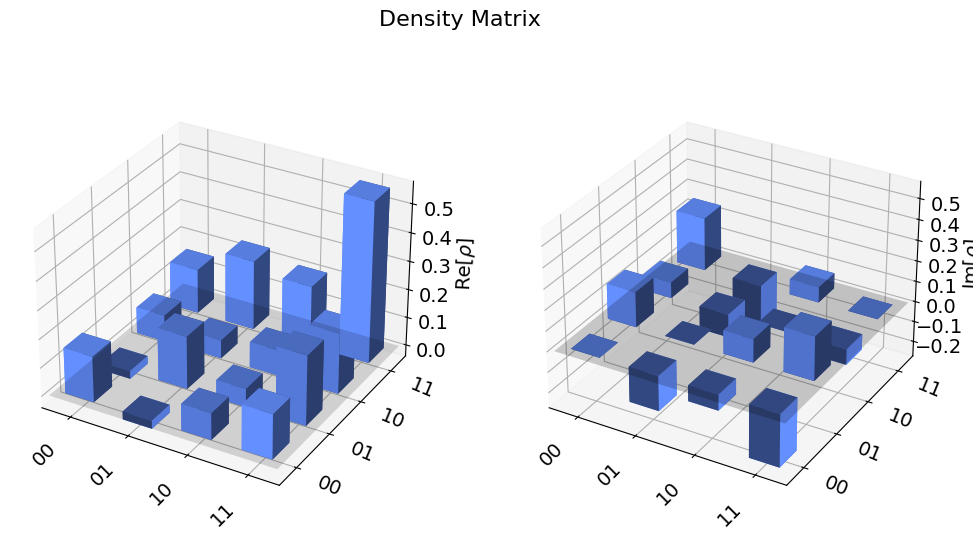

In [ ]:
plot_state_city(rho_01.data, title='Density Matrix', figsize=(12,6))

In [ ]:
gamma_p = rho_01.purity()
display(rho_01.draw('latex', prefix='\\rho_p = '))
print("State purity: ", np.round(np.real(gamma_p), 3))

<IPython.core.display.Latex object>

State purity:  1.0


In [ ]:
print(f'{entanglement_of_formation(rho_01):.4f}')

0.4837


In [ ]:
class Net(Module):
    def __init__(self, qnn):
        super().__init__()
        self.conv1 = Conv2d(3, 128, kernel_size=5)
        self.conv2 = Conv2d(128, 128, kernel_size=3)
        self.conv3 = Conv2d(128,128,kernel_size=5)
        self.dropout = Dropout2d()
        self.fc1 = Linear(758912, 128)
        self.fc2 = Linear(128, 2) # QNN binary input
        self.qnn = TorchConnector(qnn) # use TorchConnector to bind quantum node and classic convolutional layers
        self.fc3 = Linear(1, 1)  # Quantum Circuit Output

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv3(x))
        x = F.max_pool2d(x, 2)
        x = self.dropout(x)
        x = x.view(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = self.qnn(x)  # QNN in foward section
        x = self.fc3(x)
        return cat((x, 1 - x), -1)

model = Net(qnn)

In [ ]:
model = model.to('cuda')

In [ ]:
print(model)

Net(
  (conv1): Conv2d(3, 128, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(128, 128, kernel_size=(5, 5), stride=(1, 1))
  (dropout): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=758912, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=2, bias=True)
  (qnn): TorchConnector()
  (fc3): Linear(in_features=1, out_features=1, bias=True)
)


In [ ]:
summary(model, (3, 640, 640),  device='cuda')

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 128, 636, 636]       9,728
├─Conv2d: 1-2                            [-1, 128, 316, 316]       147,584
├─Conv2d: 1-3                            [-1, 128, 154, 154]       409,728
├─Dropout2d: 1-4                         [-1, 128, 77, 77]         --
├─Linear: 1-5                            [-1, 128]                 97,140,864
├─Linear: 1-6                            [-1, 2]                   258
├─TorchConnector: 1-7                    [-1, 1]                   4
├─Linear: 1-8                            [-1, 1]                   2
Total params: 97,708,168
Trainable params: 97,708,168
Non-trainable params: 0
Total mult-adds (G): 28.42
Input size (MB): 4.69
Forward/backward pass size (MB): 515.69
Params size (MB): 372.73
Estimated Total Size (MB): 893.11


Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 128, 636, 636]       9,728
├─Conv2d: 1-2                            [-1, 128, 316, 316]       147,584
├─Conv2d: 1-3                            [-1, 128, 154, 154]       409,728
├─Dropout2d: 1-4                         [-1, 128, 77, 77]         --
├─Linear: 1-5                            [-1, 128]                 97,140,864
├─Linear: 1-6                            [-1, 2]                   258
├─TorchConnector: 1-7                    [-1, 1]                   4
├─Linear: 1-8                            [-1, 1]                   2
Total params: 97,708,168
Trainable params: 97,708,168
Non-trainable params: 0
Total mult-adds (G): 28.42
Input size (MB): 4.69
Forward/backward pass size (MB): 515.69
Params size (MB): 372.73
Estimated Total Size (MB): 893.11

510
4077


In [ ]:
optimizer = optim.Adam(model.parameters(), lr=0.0001)
loss_func = CrossEntropyLoss().to('cuda')


epochs = 16
model.train()
count = 1
loss_list = []
total_accuracy = []
model_path = '/content/gdrive/My Drive/qcnn_xray.pt'
for epoch in range(epochs):
    correct = 0
    total_loss = []
    batch_size = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        batch_size+=1
        optimizer.zero_grad(set_to_none=True)
        output = model(data.to('cuda'))  # Forward pass, Data to GPU
        loss = loss_func(output, target.to('cuda')) #Labels to GPU
        loss.backward()  # Backward pass
        optimizer.step()
        total_loss.append(loss.item())
        train_pred = output.argmax(dim=1, keepdim=True)
        correct += train_pred.eq(target.to('cuda').view_as(train_pred)).sum().item()
    loss_list.append(sum(total_loss) / len(total_loss))
    accuracy = 100 * correct / 4077 # No. of training examples = 4077
    total_accuracy.append(accuracy)
    if ((100*(epoch+1))//epochs)//(count*10) >0 :
      count+=1
      print('Saving model with test loss of {:.3f}'.format(total_accuracy[-1]))
      torch.save(model.state_dict(), model_path)
    print(f"Training [{100.0 * (epoch + 1) / epochs:.0f}%]\tLoss: {loss_list[-1]:.4f}\tAccuracy: {accuracy:.2f}%")

Training [6%]	Loss: 0.3360	Accuracy: 72.92%
Saving model with test loss of 72.921
Training [12%]	Loss: 0.3117	Accuracy: 72.92%
Training [19%]	Loss: 0.2866	Accuracy: 72.92%
Saving model with test loss of 84.793
Training [25%]	Loss: 0.2639	Accuracy: 84.79%
Saving model with test loss of 94.383
Training [31%]	Loss: 0.2404	Accuracy: 94.38%
Training [38%]	Loss: 0.2200	Accuracy: 96.57%
Saving model with test loss of 97.425
Training [44%]	Loss: 0.2003	Accuracy: 97.42%
Saving model with test loss of 98.308
Training [50%]	Loss: 0.1804	Accuracy: 98.31%
Training [56%]	Loss: 0.1648	Accuracy: 98.50%
Saving model with test loss of 98.774
Training [62%]	Loss: 0.1502	Accuracy: 98.77%
Training [69%]	Loss: 0.1305	Accuracy: 99.29%
Saving model with test loss of 99.436
Training [75%]	Loss: 0.1166	Accuracy: 99.44%
Saving model with test loss of 99.460
Training [81%]	Loss: 0.1066	Accuracy: 99.46%
Training [88%]	Loss: 0.0959	Accuracy: 99.51%
Saving model with test loss of 99.706
Training [94%]	Loss: 0.0839	A

In [ ]:
model_path = '/content/gdrive/My Drive/qcnn_xray.pt'

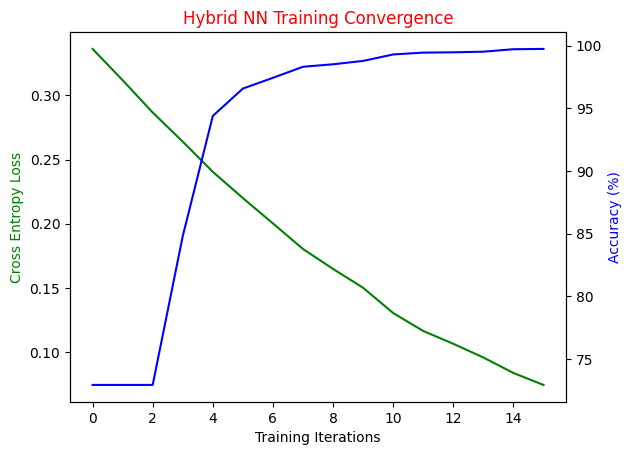

In [ ]:
fig, ax1 = plt.subplots()
ax1.plot(loss_list, 'g-')
ax2 = ax1.twinx()
ax2.plot(total_accuracy, 'b')
plt.title("Hybrid NN Training Convergence", color='red')
ax1.set_xlabel("Training Iterations")
ax1.set_ylabel("Cross Entropy Loss", color='g')
ax2.set_ylabel("Accuracy (%)", color='b')
plt.show()

In [ ]:
torch.save(model.state_dict(), model_path)

In [ ]:
qnn1 = create_qnn()
model1 = Net(qnn1)
model1.load_state_dict(torch.load(model_path))
model1= model1.to('cuda')

<ipython-input-12-7546e5320c61>:9: DeprecationWarning: The class ``qiskit.opflow.expectations.aer_pauli_expectation.AerPauliExpectation`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/opflow_migration.
  exp_val=AerPauliExpectation(),


In [ ]:
batch_size=1

model1.eval()
pred_targets = []
test_targets= []
with no_grad():

    correct = 0
    for batch_idx, (data, target) in enumerate(test_loader):
        output = model1(data.to('cuda'))
        if len(output.shape) == 1:
            output = output.reshape(1, *output.shape)

        pred = output.argmax(dim=1, keepdim=True)
        pred_targets.append(pred.item())
        test_targets.append(target.item())
        correct += pred.eq(target.to('cuda').view_as(pred)).sum().item()

        loss = loss_func(output, target.to('cuda'))
        total_loss.append(loss.item())

    print(f"Performance on test data:\n\tLoss: {sum(total_loss) / len(total_loss):.4f}\n\tAccuracy: {100 * correct / len(test_loader) / batch_size:.2f}%")

Performance on test data:
	Loss: 0.1250
	Accuracy: 95.02%


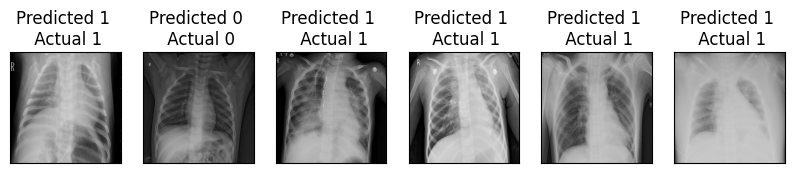

In [ ]:
from PIL import Image

n_samples_show = 6
count = 0
fig, axes = plt.subplots(nrows=1, ncols=n_samples_show, figsize=(10, 3))

model1.eval()
with no_grad():
    for batch_idx, (data, target) in enumerate(test_loader):
        if count == n_samples_show:
            break
        output = model1(data.to('cuda')[0:1])
        if len(output.shape) == 1:
            output = output.reshape(3, *output.shape)

        pred = output.argmax(dim=1, keepdim=True)
        test_targets = target.item()
        axes[count].imshow(torchvision.transforms.ToPILImage(mode='RGB')(data[0].squeeze()), cmap=plt.cm.rainbow)

        axes[count].set_xticks([])
        axes[count].set_yticks([])
        axes[count].set_title("Predicted {} \n Actual {}".format(pred.item(),test_targets))

        count += 1

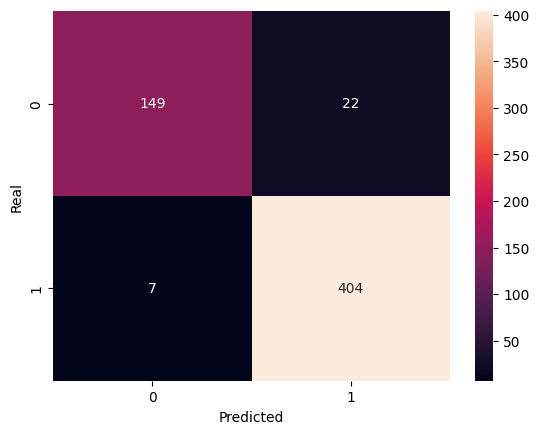

In [ ]:
matrix_confusion(test_targets, pred_targets)

In [ ]:
# Roughly 2 hours to train.